In [1]:
from importlib import reload
import os
from time import time

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.decomposition import PCA
from statsmodels.stats.weightstats import _zstat_generic

import torch
print(torch.cuda.is_available())

import pprint
import editdistance

import utils
import tdre
import shifts
import viennarna_shifts as vshifts
import calibrate as cal

import flexs
import flexs.utils.sequence_utils as s_utils

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

False


2023-12-06 00:52:51.337051: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 00:52:51.521748: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-12-06 00:52:51.521785: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-12-06 00:52:53.822585: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

<IPython.core.display.Javascript object>

# Proof-of-concept walkthrough of entire procedure

## Generate designs and characterize distribution shifts

In [ ]:
reload(vshifts)
reload(flexs)

landscape_name = 'L50_RNA1'
model_name = 'lin reg' # for plot title
seed_idx = 4
n = 10000
N = 5000
avg_n_mut = 4
noise_sd = 0.02

model_class = flexs.baselines.models.LinearRegression
model_kwargs = {}

# model_class = flexs.baselines.models.RidgeCV
# model_kwargs = {
#     'alphas': [1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
#     'cv': 5
# }

# model_class = flexs.baselines.models.CNN
# model_kwargs = {
#     'num_filters': 64,
#     'hidden_size': 64,
#     'loss': 'MSE',
#     'batch_size': 512,
# }

explorer = 'adalead'
thresholds = [0.8, 0.5, 0.3, 0.1, 0.01]

t0 = time()
flexsshift = vshifts.FLEXSShift(landscape_name, noise_sd=noise_sd)
trainseqs_n, ytrain_n, calseqs_n, ycal_n, predcal_n, testseqs_list, yseed = flexsshift.get_data(
    n,
    model_class,
    explorer,
    {'threshold': thresholds},
    model_kwargs=model_kwargs,
    n_cal=n - N,
    N=N,
    seed_idx=seed_idx,
    avg_n_mut=avg_n_mut,
    save_fname_prefix=None
)
print(int(time() - t0))

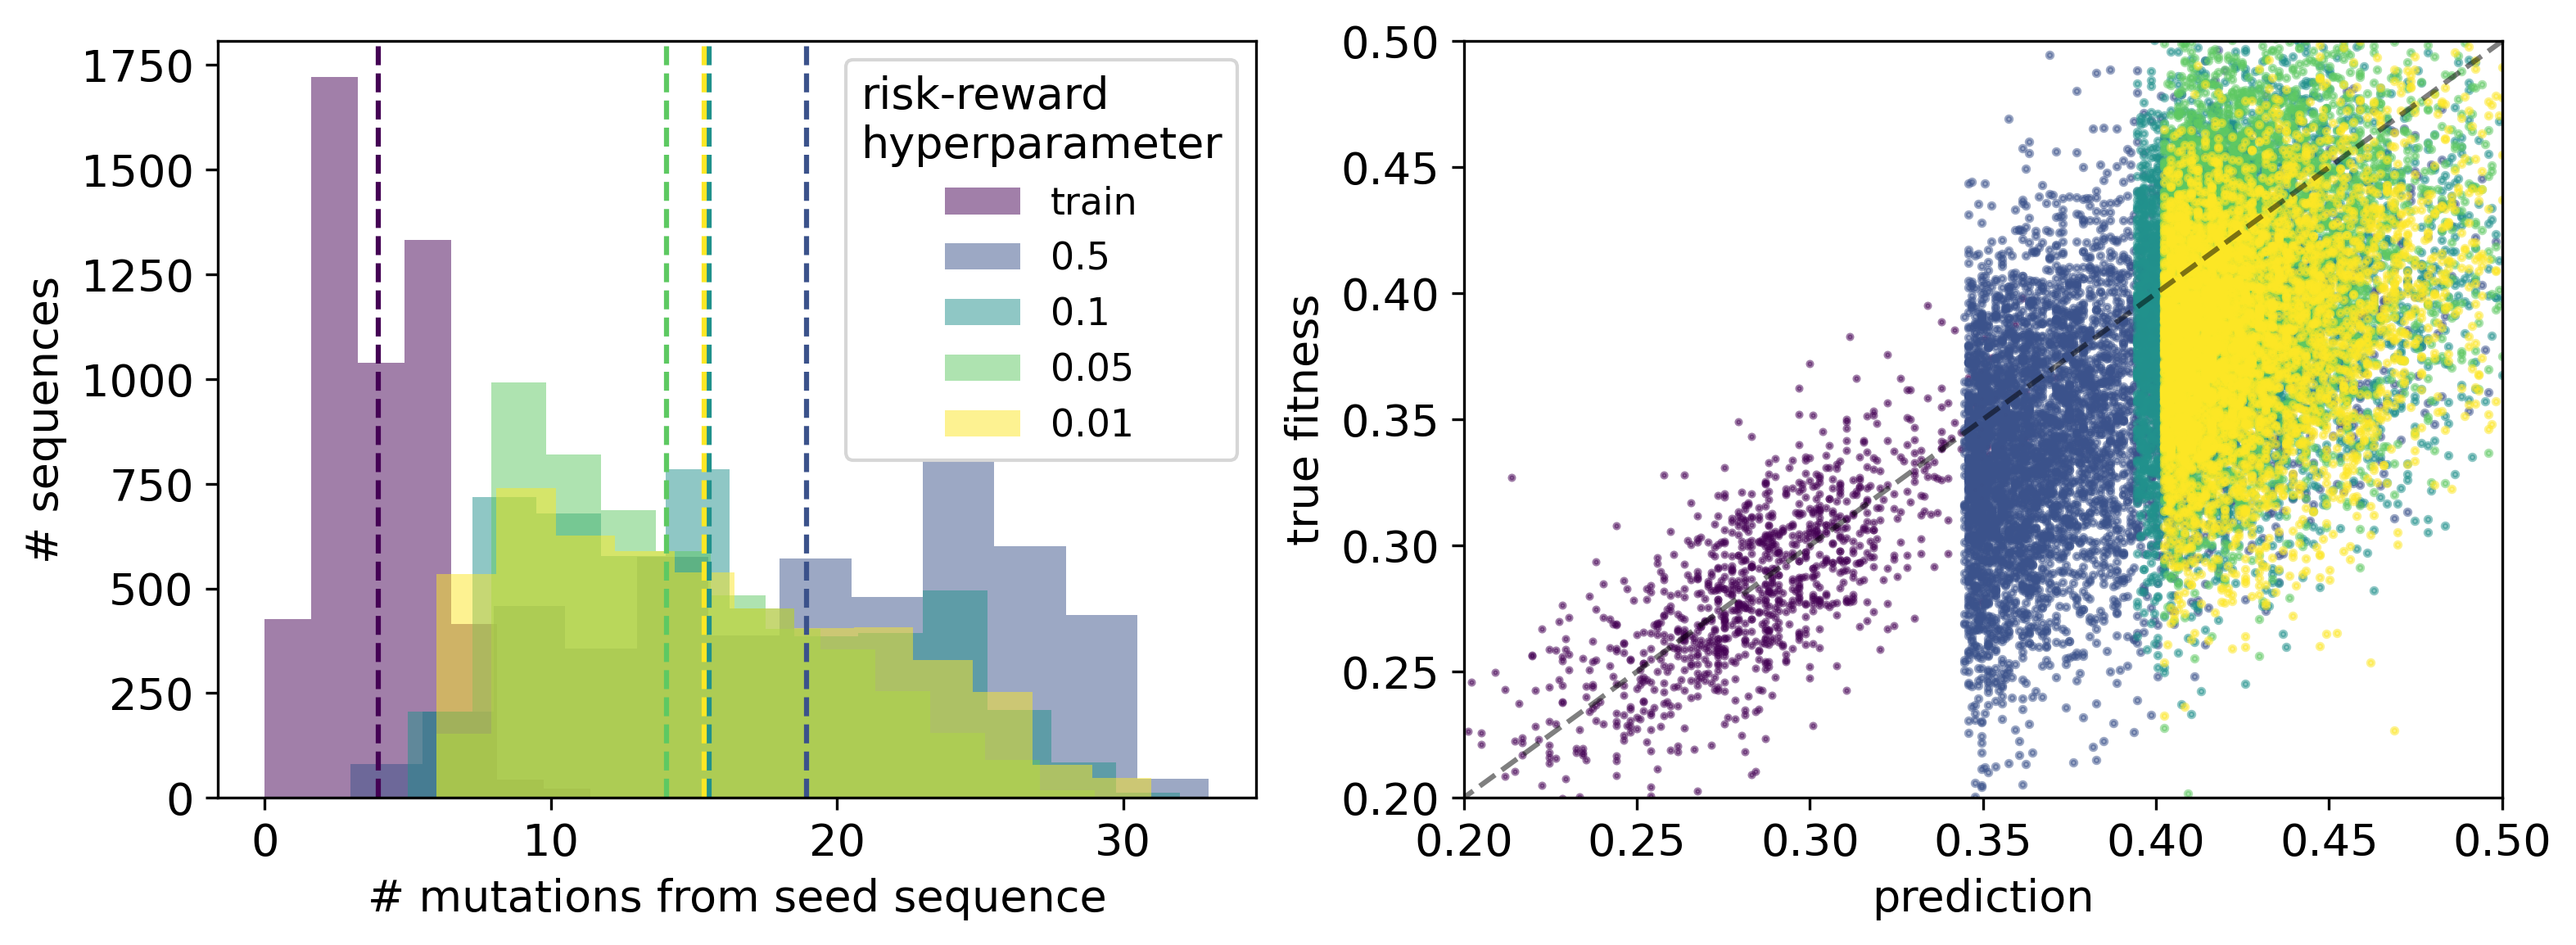

In [42]:
# pretty plot for presentations
scatter_lim = [0.2, 0.5]
n_bins = 12
font = {'size' : 13}
matplotlib.rc('font', **font)
scatter_s = 3
cmap = matplotlib.cm.get_cmap('viridis')
disttrain_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in trainseqs_n])

plt.figure(figsize=(12, 4), dpi=300)

plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, label='train', bins=8, color=cmap(0));
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=cmap(0))
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');

plt.subplot(122)
plt.scatter(predcal_n, ycal_n, alpha=0.5, s=2, label='validation', color=cmap(0));
# plt.scatter(np.mean(ycal_n), np.mean(predcal_n), color=cmap(0), alpha=1, s=15, edgecolor='k');
plt.plot([0, 1], [0, 1], '--k', alpha=0.5);
plt.xlim(scatter_lim);
plt.ylim(scatter_lim);
plt.ylabel('true fitness');
plt.xlabel('prediction');

for i, (testseqs_n, ytest_n, predtest_n) in enumerate(testseqs_list):
    color = cmap((i + 1) / len(thresholds))
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, label=thresholds[i], color=color, bins=n_bins);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=color)
    
    plt.subplot(122)
    plt.scatter(predtest_n, ytest_n, alpha=0.5, s=scatter_s, color=color);
    # plt.scatter(np.mean(ytest_n), np.mean(predtest_n), color=color, alpha=1, s=10, edgecolor='k');
plt.subplot(121)
plt.legend(title='risk-reward\nhyperparameter', fontsize=11);

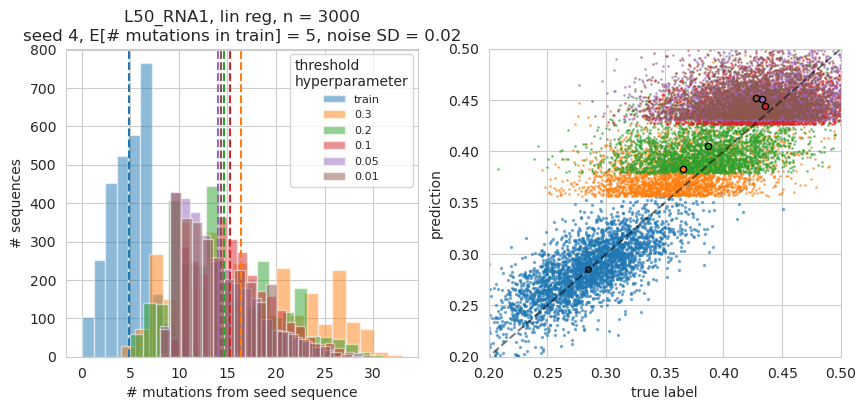

In [13]:
# plot characterizing distribution shifts
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
disttrain_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in trainseqs_n])

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.hist(disttrain_n, alpha=0.5, bins=10, label='train');
plt.axvline(np.mean(disttrain_n), alpha=1, linestyle='--', color=colors[0])
plt.subplot(122)
plt.scatter(ycal_n, predcal_n, alpha=0.5, s=2, label='validation');

for i, thing in enumerate(testseqs_list):
    testseqs_n, ytest_n, predtest_n = thing
    ci = (i + 1) % len(colors)
    
    plt.subplot(121)
    disttest_n = np.array([editdistance.eval(flexsshift.problem['starts'][seed_idx], s) for s in testseqs_n])
    plt.hist(disttest_n, alpha=0.5, bins=20, label=thresholds[i]);
    plt.axvline(np.mean(disttest_n), linestyle='--', color=colors[ci])
    
    plt.subplot(122)
    plt.scatter(ytest_n, predtest_n, alpha=0.5, s=1);
    plt.scatter(np.mean(ytest_n), np.mean(predtest_n), color=colors[ci], alpha=1, s=10, edgecolor='k');

# plot means
plt.subplot(122)
plt.scatter(np.mean(ycal_n), np.mean(predcal_n), color=colors[0], alpha=1, s=15, edgecolor='k');
for i, thing in enumerate(testseqs_list):
    testseqs_n, ytest_n, predtest_n = thing
    ci = (i + 1) % len(colors)
    
    plt.subplot(122)
    plt.scatter(np.mean(ytest_n), np.mean(predtest_n), color=colors[ci], alpha=1, s=20, edgecolor='k');
    

plt.subplot(121)
plt.legend(title='threshold\nhyperparameter', fontsize=8);
plt.xlabel('# mutations from seed sequence');
plt.ylabel('# sequences');
plt.title('{}, {}, n = {}\nseed {}, E[# mutations in train] = {}, noise SD = {}'.format(
    landscape_name, model_name, n, seed_idx, avg_n_mut, noise_sd))

plt.subplot(122)
plt.plot([0, 1], [0, 1], '--k', alpha=0.5);
plt.xlim([0.2, 0.5]);
plt.ylim([0.2, 0.5]);
plt.xlabel('true label');
plt.ylabel('prediction');

In [11]:
np.savez(
    '{}-seed{}-n{}-mut{}-nsd{}-112123.npz'.format(landscape_name, seed_idx, n, avg_n_mut, noise_sd),
    trainseqs_n=trainseqs_n,
    ytrain_n=ytrain_n,
    calseqs_n=calseqs_n,
    ycal_n=ycal_n,
    predcal_n=predcal_n,
    testseqs_list=testseqs_list,
    yseed=yseed
)

Load generated data

In [2]:
landscape_name = 'L50_RNA1'
seed_idx = 4
n = 5000
avg_n_mut = 4
noise_sd = 0.02
d = np.load(
    '{}-seed{}-n{}-mut{}-nsd{}-112123.npz'.format(landscape_name, seed_idx, n, avg_n_mut, noise_sd),
)
trainseqs_n = list(d['trainseqs_n'])
ytrain_n = d['ytrain_n']
calseqs_n = list(d['calseqs_n'])
ycal_n = d['ycal_n']
predcal_n = d['predcal_n']
testseqs_list = [
    [list(thing[0]), thing[1].astype(float), thing[2].astype(float)]
    for thing in list(d['testseqs_list'])
]
testseqs_list = testseqs_list[::-1]  # to get [0] = most severe design. this Rhodes ordering is insanity
yseed = float(d['yseed'])

In [4]:
# sanity check ordering, true means should decrease
reload(vshifts)
X_m1xnxd, y_m1xn, pred_mxn, Xcal_nxd = vshifts.process_getted_data(
    trainseqs_n, ytrain_n, calseqs_n, testseqs_list
)
for i, y_n in enumerate(y_m1xn):
    print(i, '{:.3f}'.format(np.mean(y_n)))

0 0.383
1 0.400
2 0.385
3 0.371
4 0.355
5 0.284


## Learn density ratios

In [6]:
reload(tdre)
d = 50 * 4
m = X_m1xnxd.shape[0] - 1
n_hidden = 8
device = torch.device('cuda')
dtype = torch.float
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}

model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    # tdre.Quadratic,
    lambda x: tdre.FeedForward(x, n_hidden=n_hidden),
    d,
    n_ratio=m,
    device=device,
    dtype=dtype
)

train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)

ytest_n = y_m1xn[0]
predtest_n = pred_mxn[0]

truemean_m = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
imputed_m = np.array([np.mean(pred_n) for pred_n in pred_mxn])
classicaltr_m, cltrdr_nxm = model.forecast_meany_per_bridge(
    X_m1xnxd[-1], y_m1xn[-1], self_normalized=True
)
classical_m, cldr_nxm = model.forecast_meany_per_bridge(
    Xcal_nxd, ycal_n, self_normalized=True
)
pp_m, ppdr_nxm = model.forecast_meany_per_bridge(
    Xcal_nxd, ycal_n, predm_n=predcal_n, pred0_n=predtest_n, self_normalized=True
)
# classicaltr_m, cltrdr_nxm = model.forecast_meany_per_bridge(
#     X_m1xnxd[-1], y_m1xn[-1], predm_n=, pred0_n=predtest_n, self_normalized=True
# )


print(truemean_m)
print(classical_m)
print(classicaltr_m)
print(pp_m)
print(imputed_m)

5 waymarks provided


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 340.00it/s]


Done fitting bridge 1 / 5 (14 s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 364.11it/s]


Done fitting bridge 2 / 5 (28 s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 366.63it/s]


Done fitting bridge 3 / 5 (42 s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 382.63it/s]


Done fitting bridge 4 / 5 (55 s).


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 355.57it/s]

Done fitting bridge 5 / 5 (69 s).
[0.38324085 0.39993838 0.3854932  0.37124701 0.35544619]
[0.30813997 0.36575918 0.38052298 0.36196751 0.36138173]
[0.31583038 0.42076006 0.367523   0.35913222 0.39225851]
[0.39842554 0.41616784 0.43172162 0.38985407 0.39270652]
[0.41646133 0.43132422 0.41289336 0.39987422 0.38460195]


In [6]:
truemean_m = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
classical_m, clweightedy_nxm = model.forecast_meany_per_bridge(
    Xcal_nxd, ycal_n, self_normalized=True
)
classicaltr_m, cltrweightedy_nxm = model.forecast_meany_per_bridge(
    X_m1xnxd[-1], y_m1xn[-1], self_normalized=True
)
imputed_m = np.array([np.mean(pred_n) for pred_n in pred_mxn])

print(truemean_m)
print(classical_m)
print(classicaltr_m)
print(imputed_m)

[0.38324085 0.39993838 0.3854932  0.37124701 0.35544619]
[0.35047729 0.32394043 0.41499001 0.36208313 0.39628389]
[0.32963346 0.42097723 0.3883085  0.33065689 0.35114151]
[0.41646133 0.43132422 0.41289336 0.39987422 0.38460195]


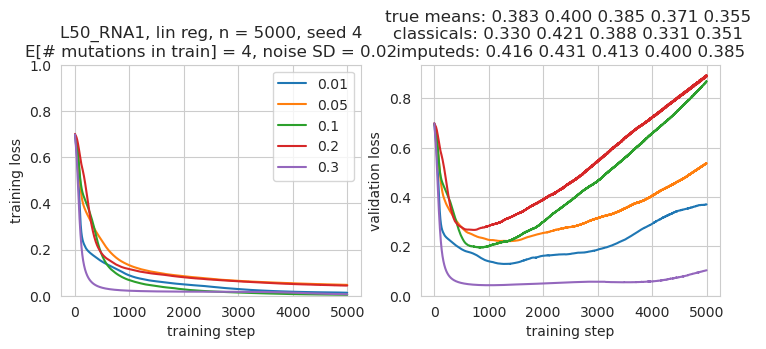

In [7]:
thresholds = [0.3, 0.2, 0.1, 0.05, 0.01]
model_name = 'lin reg'
m_to_plot = 5

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss'], label=thresholds[::-1][i]);
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.title('{}, {}, n = {}, seed {}\nE[# mutations in train] = {}, noise SD = {}'.format(
    landscape_name, model_name, n, seed_idx, avg_n_mut, noise_sd))
plt.legend()
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('validation loss');
fstr = ''.join(m * ['{:.3f} '])
format_str = 'true means: {}\nclassicals: {}\n imputeds: {}'.format(fstr, fstr, fstr)
values = np.hstack([truemean_m, classicaltr_m, imputed_m])
plt.title(format_str.format(*values));

## p-values

In [9]:
Xm_nxp = X_m1xnxd[-1]
ym_n = y_m1xn[-1]

tXm_nxp = torch.from_numpy(Xm_nxp).to(device=model.device, dtype=model.dtype)
ldr_nxm = model._get_ldr_nxm(tXm_nxp).cpu().detach().numpy()
# m = 0 corresponds to going to design distribution, so flip for cumsum
ldr_nxm = np.fliplr(np.cumsum(np.fliplr(ldr_nxm), axis=1))
# ldr_nxm = np.fmin(ldr_nxm, 0)  # reflecting our "prior" about log DRs for data from train distribution

c_1xm = np.max(ldr_nxm, axis=0, keepdims=True)
normalization_1xm = c_1xm + np.log(np.sum(np.exp(ldr_nxm - c_1xm), axis=0, keepdims=True))
normalizeddr_nxm = np.exp(ldr_nxm - normalization_1xm)
dr_nxm = np.exp(ldr_nxm)
# dr_nxm = dr_nxm / np.sum(dr_nxm, axis=0, keepdims=True)  # equivalent to normalizeddr_nxm

weightedym_nxm = normalizeddr_nxm * ym_n[:, None]
# restore to m = 0 corresponding to design distribution
forecast_m = np.sum(weightedym_nxm, axis=0, keepdims=False)
print(forecast_m)

[0.32963346 0.42097723 0.3883085  0.33065689 0.35114151]


In [23]:
# lol just copy-pasting the label of a single training point
idx = np.where(normalizeddr_nxm[:, 0] > 0.01)[0][0]
ym_n[idx], forecast_m

(0.32963204593160594,
 array([0.32963346, 0.42097723, 0.3883085 , 0.33065689, 0.35114151]))

In [13]:
tau = 0.38
for i in range(var_m.size):
    zstat, pval = _zstat_generic(forecast_m[i], 0, np.sqrt(var_m[i]), alternative='larger', diff=tau)
    print('{:.3f} {:.3f} {:.5f} {:.2f} {:.5f}'.format(
        truemean_m[i], forecast_m[i], np.sqrt(var_m[i]), zstat, pval))

0.383 0.330 0.00000 -27360.60 1.00000
0.400 0.421 0.00000 2368945.81 0.00000
0.385 0.388 0.00000 42765.29 0.00000
0.371 0.331 0.00365 -13.51 1.00000
0.355 0.351 0.00087 -33.02 1.00000


## Load trial data

In [11]:
%%notify
reload(vshifts)
reload(cal)
reload(tdre)

# data 
landscape_name = 'L50_RNA1'
seed_idx = 4
n = 4000
avg_n_mut = 5
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
explorer_kwarg_name2vals = {'threshold': thresholds}
save_fname_dir = '112823'
n_trial = 10
tau = 0.38
alpha = 0.1
lhat = 1

# TDRE
n_hidden = 16
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 2000,
    'lr': 1e-3,
}
model = tdre.TelescopingLogDensityRatioEstimator(
    tdre.FeedForward,
    50 * 4,
    shared=False,
    n_ratio=len(thresholds),
    device=torch.device('cuda'),
    dtype=torch.float
)

truemean_tx2 = np.zeros([n_trial, 2])
sz_t = np.zeros([n_trial])
fwer = 0

imptruemean_tx2 = np.zeros([n_trial, 2])
impsz_t = np.zeros([n_trial])
impfwer = 0

pptruemean_tx2 = np.zeros([n_trial, 2])
ppsz_t = np.zeros([n_trial])
ppfwer = 0
format_str = ''.join(['{}'] + len(thresholds) * ['{:.3f} '])
pval_format_str = ''.join(len(thresholds) * ['{:.3f} '])
for t in range(n_trial):

    X_m1xnxd, y_m1xn, pred_mxn, Xcal_nxd, ycal_n, predcal_n = vshifts.load_rna_data(
        landscape_name,
        seed_idx,
        n,
        explorer_kwarg_name2vals,
        save_fname_dir,
        avg_n_mut,
        t
    )
    
    train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)
    
    truemean_m = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
    
    # imputation estimate
    imputed_m = np.array([np.mean(pred_n) for pred_n in pred_mxn])
    
    # classical estimates on calibration data
    classical_m, cldr_nxm = model.forecast_meany_per_bridge(
        Xcal_nxd, ycal_n, self_normalized=True
    )
    # PP estimates
    pp_m, ppdr_nxm = model.forecast_meany_per_bridge(
        Xcal_nxd, ycal_n, self_normalized=True, predm_n=predcal_n, pred0_mxn=pred_mxn
    )
    
    print('train: {:.3f}'.format(np.mean(ycal_n)))
    print(format_str.format('true:  ', *truemean_m))
    print(format_str.format('cl cal:', *classical_m))
    print(format_str.format('pp    :', *pp_m))
    print(format_str.format('impute:', *imputed_m))
    
    print('Classical:')
    pvals = [  # TODO: n or n - 1 for std?
        _zstat_generic(cl_est, 0, np.std(cldr_n * ycal_n) / np.sqrt(ycal_n.size), alternative='larger', diff=tau)[1]  
        for cl_est, cldr_n in zip(classical_m, cldr_nxm.T)
    ]
    print(pval_format_str.format(*pvals))
    idx = np.where(np.array(pvals) < alpha / len(thresholds))[0]
    if idx.size:
        truemean_tx2[t] = np.min(truemean_m[idx]), np.max(truemean_m[idx])  # true quantity of most aggressive hyperparameter
        sz_t[t] = idx.size
        if np.sum(truemean_m[idx] > tau) < idx.size:
            fwer += 1
        print('  {:.3f} {:.3f}. {} {}'.format(truemean_tx2[t, 0], truemean_tx2[t, 1], idx.size, fwer))
    else:
        print('  No hyperparameters selected')
    
    print('Imputed:')
    imppvals = [
        _zstat_generic(imp_est, 0, np.std(pred0_n) / np.sqrt(pred0_n.size), alternative='larger', diff=tau)[1]
        for imp_est, pred0_n in zip(imputed_m, pred_mxn)]
    print(pval_format_str.format(*imppvals))
    impidx = np.where(np.array(imppvals) < alpha / len(thresholds))[0]
    if impidx.size:
        imptruemean_tx2[t] = np.min(truemean_m[impidx]), np.max(truemean_m[impidx])  # true quantity of most aggressive hyperparameter
        impsz_t[t] = impidx.size
        if np.sum(truemean_m[impidx] > tau) < impidx.size:
            impfwer += 1
        print('  {:.3f} {:.3f}. {} {}'.format(imptruemean_tx2[t, 0], imptruemean_tx2[t, 1], impidx.size, impfwer))
    else:
        print('  No hyperparameters selected')
    
    print('PPI++:')
    pppvals = [
        cal.ppi_mean_pval(
            ycal_n, predcal_n, pred0_n,
            lhat=lhat, null=tau, alternative='larger', w=dr_n
        ) for pred0_n, dr_n in zip(pred_mxn, ppdr_nxm.T)
    ]
    print(pval_format_str.format(*pppvals))
    ppidx = np.where(np.array(pppvals) < alpha / len(thresholds))[0]
    if ppidx.size:
        pptruemean_tx2[t] = np.min(truemean_m[ppidx]), np.max(truemean_m[ppidx])
        ppsz_t[t] = ppidx.size
        if np.sum(truemean_m[ppidx] > tau) < ppidx.size:
            ppfwer += 1
        print('  {:.3f} {:.3f}. {} {}'.format(
            pptruemean_tx2[t, 0], pptruemean_tx2[t, 1], ppidx.size, ppfwer))
    else:
        print('  No hyperparameters selected')
    
fwer /= n_trial
impfwer /= n_trial
ppfwer /= n_trial

ppnonempty_idx = np.where(ppsz_t)[0]
print('PP : min true value {:.3f}, FWER {:.2f}, # selected {:.2f}, discovery rate {:.2f}'.format(
    np.median(pptruemean_tx2[ppnonempty_idx, 0]),
    ppfwer,
    np.median(ppsz_t),
    ppnonempty_idx.size / n_trial,
    )
)
impnonempty_idx = np.where(impsz_t)[0]
print('imp: min true value {:.3f}, FWER {:.2f}, # selected {:.2f}, discovery rate {:.2f}'.format(
    np.median(imptruemean_tx2[impnonempty_idx, 0]),
    impfwer,
    np.median(impsz_t),
    impnonempty_idx.size / n_trial,
    )
)
    

Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.2.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.3.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.4.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial0/seed4-n4000-nmut5-threshold0.5.npz
7 waymarks provided


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 407.39it/s]


Done fitting bridge 1 / 7 (4 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 388.85it/s]


Done fitting bridge 2 / 7 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.98it/s]


Done fitting bridge 3 / 7 (15 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 341.92it/s]


Done fitting bridge 4 / 7 (21 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.68it/s]


Done fitting bridge 5 / 7 (26 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.46it/s]


Done fitting bridge 6 / 7 (32 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 352.85it/s]


Done fitting bridge 7 / 7 (38 s).
train: 0.282
true:  0.436 0.434 0.417 0.383 0.363 0.351 0.345 
cl cal:0.455 0.455 0.455 0.455 0.420 0.301 0.289 
pp    :0.487 0.485 0.473 0.456 0.425 0.349 0.341 
impute:0.437 0.434 0.423 0.406 0.391 0.376 0.376 
Classical:
0.434 0.434 0.434 0.434 0.448 0.624 0.625 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 1.000 1.000 
  0.363 0.436. 5 1
PPI++:
0.016 0.018 0.032 0.064 0.066 0.858 0.867 
  No hyperparameters selected
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial1/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial1/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial1/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/da

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.41it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 353.53it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 352.21it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 364.73it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 366.44it/s]


Done fitting bridge 5 / 7 (27 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 366.62it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.47it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.284
true:  0.381 0.384 0.385 0.367 0.354 0.343 0.337 
cl cal:0.321 0.321 0.321 0.321 0.321 0.332 0.325 
pp    :0.368 0.370 0.363 0.350 0.342 0.334 0.332 
impute:0.415 0.417 0.410 0.396 0.389 0.372 0.375 
Classical:
0.573 0.573 0.573 0.573 0.573 0.558 0.592 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 1.000 1.000 
  0.354 0.385. 5 2
PPI++:
0.601 0.587 0.641 0.741 0.793 0.890 0.931 
  No hyperparameters selected
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial2/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial2/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial2/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/da

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 343.07it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 356.99it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.38it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 354.76it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.38it/s]


Done fitting bridge 5 / 7 (28 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 367.44it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.33it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.284
true:  0.386 0.377 0.375 0.369 0.354 0.346 0.341 
cl cal:0.392 0.361 0.371 0.340 0.316 0.333 0.333 
pp    :0.443 0.396 0.408 0.376 0.350 0.354 0.351 
impute:0.404 0.404 0.402 0.395 0.383 0.377 0.374 
Classical:
0.487 0.530 0.514 0.557 0.600 0.556 0.556 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 1.000 1.000 
  0.354 0.386. 5 3
PPI++:
0.045 0.068 0.001 0.597 0.859 0.876 0.902 
  0.375 0.375. 1 1
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial3/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial3/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial3/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/112823/L

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 343.19it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.57it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.19it/s]


Done fitting bridge 3 / 7 (17 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 366.34it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.84it/s]


Done fitting bridge 5 / 7 (28 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.40it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.57it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.285
true:  0.410 0.405 0.401 0.375 0.356 0.344 0.342 
cl cal:0.306 0.306 0.311 0.306 0.306 0.306 0.306 
pp    :0.393 0.395 0.392 0.364 0.355 0.340 0.337 
impute:0.424 0.425 0.422 0.394 0.385 0.370 0.368 
Classical:
0.596 0.596 0.597 0.596 0.596 0.596 0.596 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 1.000 1.000 
  0.356 0.410. 5 4
PPI++:
0.330 0.315 0.335 0.704 0.797 0.907 0.920 
  No hyperparameters selected
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial4/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial4/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial4/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/da

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.90it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 367.81it/s]


Done fitting bridge 2 / 7 (10 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 367.06it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.83it/s]


Done fitting bridge 4 / 7 (21 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.46it/s]


Done fitting bridge 5 / 7 (27 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 362.92it/s]


Done fitting bridge 6 / 7 (32 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 341.45it/s]


Done fitting bridge 7 / 7 (38 s).
train: 0.284
true:  0.412 0.400 0.385 0.370 0.354 0.340 0.339 
cl cal:0.340 0.340 0.340 0.340 0.343 0.340 0.340 
pp    :0.410 0.401 0.386 0.372 0.364 0.351 0.352 
impute:0.436 0.427 0.412 0.398 0.388 0.378 0.378 
Classical:
0.547 0.547 0.547 0.547 0.546 0.547 0.547 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 1.000 1.000 
  0.354 0.412. 5 5
PPI++:
0.124 0.209 0.405 0.618 0.734 0.863 0.861 
  No hyperparameters selected
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial5/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial5/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial5/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/da

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.18it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 365.00it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 373.22it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 364.00it/s]


Done fitting bridge 4 / 7 (21 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.49it/s]


Done fitting bridge 5 / 7 (27 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.15it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.59it/s]


Done fitting bridge 7 / 7 (38 s).
train: 0.284
true:  0.416 0.405 0.397 0.376 0.360 0.351 0.345 
cl cal:0.350 0.350 0.350 0.378 0.357 0.309 0.309 
pp    :0.412 0.399 0.390 0.415 0.388 0.365 0.359 
impute:0.439 0.426 0.416 0.403 0.385 0.380 0.373 
Classical:
0.534 0.534 0.534 0.503 0.553 0.598 0.594 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 0.154 1.000 
  0.360 0.416. 5 6
PPI++:
0.113 0.237 0.360 0.005 0.116 0.869 0.936 
  0.376 0.376. 1 2
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial6/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial6/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial6/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/112823/L

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.10it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.35it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 345.10it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 344.73it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 340.73it/s]


Done fitting bridge 5 / 7 (28 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.92it/s]


Done fitting bridge 6 / 7 (34 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 360.80it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.285
true:  0.389 0.380 0.380 0.361 0.353 0.346 0.342 
cl cal:0.367 0.367 0.367 0.367 0.367 0.367 0.367 
pp    :0.398 0.397 0.397 0.387 0.378 0.376 0.372 
impute:0.398 0.396 0.396 0.386 0.377 0.375 0.371 
Classical:
0.514 0.514 0.514 0.514 0.514 0.514 0.514 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 1.000 1.000 1.000 
  0.361 0.389. 4 7
PPI++:
0.000 0.000 0.000 0.000 0.974 1.000 1.000 
  0.361 0.389. 4 3
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial7/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial7/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial7/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/112823/L

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.71it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 365.29it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.25it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.49it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.34it/s]


Done fitting bridge 5 / 7 (28 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.39it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 356.31it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.284
true:  0.375 0.396 0.390 0.369 0.350 0.341 0.342 
cl cal:0.369 0.368 0.369 0.337 0.331 0.328 0.369 
pp    :0.418 0.431 0.439 0.422 0.406 0.392 0.402 
impute:0.401 0.435 0.427 0.407 0.393 0.380 0.385 
Classical:
0.512 0.520 0.515 0.558 0.562 0.567 0.512 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 0.706 0.000 
  0.342 0.396. 6 8
PPI++:
0.012 0.000 0.000 0.000 0.031 0.185 0.097 
  0.369 0.396. 4 4
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial8/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial8/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial8/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/data/112823/L

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 365.47it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 359.15it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.82it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 363.47it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.73it/s]


Done fitting bridge 5 / 7 (27 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 364.10it/s]


Done fitting bridge 6 / 7 (33 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 361.24it/s]


Done fitting bridge 7 / 7 (38 s).
train: 0.283
true:  0.395 0.389 0.383 0.363 0.357 0.345 0.342 
cl cal:0.326 0.334 0.352 0.358 0.325 0.349 0.349 
pp    :0.362 0.348 0.348 0.333 0.352 0.360 0.357 
impute:0.430 0.414 0.410 0.395 0.384 0.384 0.381 
Classical:
0.566 0.570 0.539 0.525 0.568 0.537 0.537 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 0.000 0.000 0.129 
  0.345 0.395. 6 9
PPI++:
0.605 0.726 0.741 0.786 0.810 0.810 0.847 
  No hyperparameters selected
Problem has sequence length 50
Loading waymarks in the following order for k = 0, 1, ..., m where k = 0 is the target design distribution.
[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial9/seed4-n4000-nmut5-threshold0.01.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial9/seed4-n4000-nmut5-threshold0.05.npz
Loading from /data/wongfanc/dre-data/data/112823/L50_RNA1/trial9/seed4-n4000-nmut5-threshold0.1.npz
Loading from /data/wongfanc/dre-data/da

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 358.68it/s]


Done fitting bridge 1 / 7 (5 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 356.38it/s]


Done fitting bridge 2 / 7 (11 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 369.32it/s]


Done fitting bridge 3 / 7 (16 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 343.56it/s]


Done fitting bridge 4 / 7 (22 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 342.77it/s]


Done fitting bridge 5 / 7 (28 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 346.68it/s]


Done fitting bridge 6 / 7 (34 s).


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 340.90it/s]


Done fitting bridge 7 / 7 (39 s).
train: 0.283
true:  0.424 0.417 0.391 0.374 0.359 0.347 0.345 
cl cal:0.374 0.374 0.341 0.341 0.394 0.341 0.341 
pp    :0.418 0.414 0.399 0.384 0.415 0.360 0.356 
impute:0.428 0.425 0.405 0.391 0.376 0.367 0.362 
Classical:
0.507 0.507 0.545 0.545 0.486 0.545 0.545 
  No hyperparameters selected
Imputed:
0.000 0.000 0.000 0.000 1.000 1.000 1.000 
  0.374 0.424. 4 10
PPI++:
0.000 0.000 0.001 0.248 0.182 0.999 1.000 
  0.391 0.424. 3 4
PP : min true value 0.375, FWER 0.40, # selected 0.50, discovery rate 0.50
imp: min true value 0.355, FWER 1.00, # selected 5.00, discovery rate 1.00


<IPython.core.display.Javascript object>

0.01 4


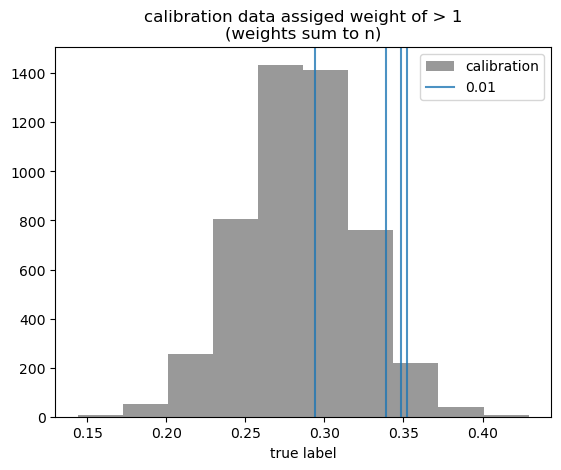

In [56]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plt.hist(y_m1xn[-1], alpha=0.8, color='gray', label='training')
plt.hist(ycal_n, alpha=0.8, color='gray', label='calibration')
for i in range(len(thresholds)):
    idx = np.where(cldr_nxm[:, i] > 1)[0]
    print(thresholds[4 - i], idx.size)
    for ii, j in enumerate(idx):
        plt.axvline(ycal_n[j], alpha=0.8, color=colors[i], label=thresholds[4 - i] if ii == 0 else None)
plt.legend();
plt.xlabel('true label');
plt.title('calibration data assiged weight of > 1\n(weights sum to n)');

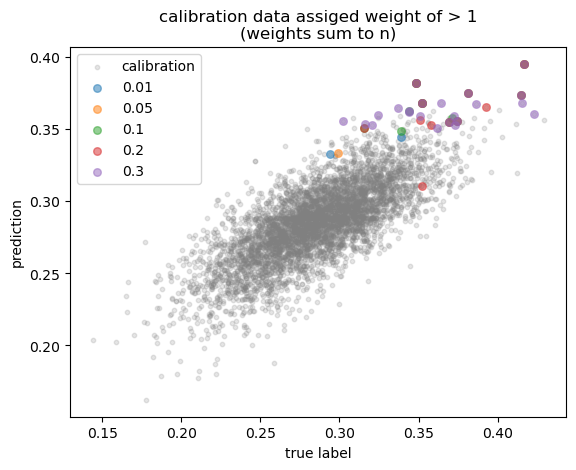

In [50]:
plt.scatter(ycal_n, predcal_n, alpha=0.2, s=10, c='gray', label='calibration')
for i in range(len(thresholds)):
    idx = np.where(cldr_nxm[:, i] > 1)[0]
    plt.scatter(ycal_n[idx], predcal_n[idx], alpha=0.5, s=30, label=thresholds[4 - i])
plt.legend();
plt.xlabel('true label');
plt.ylabel('prediction');
plt.title('calibration data assiged weight of > 1\n(weights sum to n)');

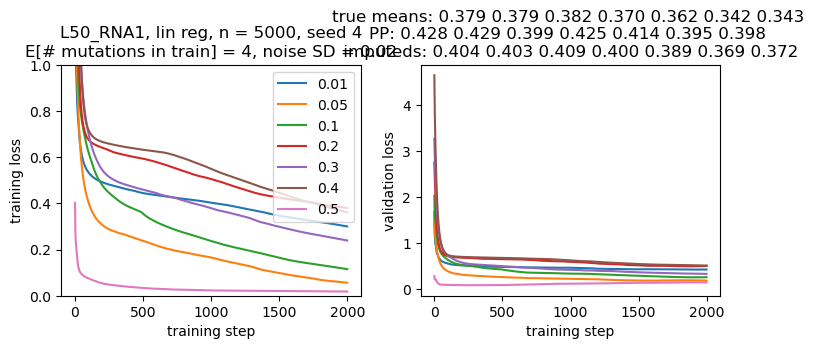

In [36]:
thresholds = [0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01]
model_name = 'lin reg'
m_to_plot = 7
noise_sd = 0.02
m = len(thresholds)

plt.figure(figsize=(8.5, 3))
plt.subplot(121)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['train_loss'], label=thresholds[::-1][i]);
plt.xlabel('training step');
plt.ylabel('training loss'); 
plt.title('{}, {}, n = {}, seed {}\nE[# mutations in train] = {}, noise SD = {}'.format(
    landscape_name, model_name, n, seed_idx, avg_n_mut, noise_sd))
plt.legend()
plt.ylim([0, 1]);

plt.subplot(122)
for i in range(m_to_plot):
    plt.plot(train_dfs[i]['val_loss']);
plt.xlabel('training step');
plt.ylabel('validation loss');
fstr = ''.join(m * ['{:.3f} '])
format_str = 'true means: {}\nPP: {}\n imputeds: {}'.format(fstr, fstr, fstr)
values = np.hstack([truemean_m, pp_m, imputed_m])
plt.title(format_str.format(*values));

In [ ]:
# no PPI
%%notify
reload(vshifts)

# data 
landscape_name = 'L50_RNA1'
seed_idx = 4
n = 5000
avg_n_mut = 4
thresholds = [0.01, 0.05, 0.1, 0.2, 0.3]
explorer_kwarg_name2vals = {'threshold': thresholds}
save_fname_dir = '112123'
n_trial = 10
tau = 0.38
alpha = 0.1

# TDRE
n_hidden = 8
config = {
    'waymark_type': 'mixed_dimensions',  # dummy value
    'val_frac': 0.1,
    'n_steps': 5000,
    'lr': 1e-3,
}
model = tdre.UnsharedTelescopingLogDensityRatioEstimator(
    lambda x: tdre.FeedForward(x, n_hidden=n_hidden),
    50 * 4,
    n_ratio=len(thresholds),
    device=torch.device('cuda'),
    dtype=torch.float
)

truemean_tx2 = np.zeros([n_trial, 2])
sz_t = np.zeros([n_trial])
fwer = 0

imptruemean_tx2 = np.zeros([n_trial, 2])
impsz_t = np.zeros([n_trial])
impfwer = 0
for t in range(n_trial):

    X_m1xnxd, y_m1xn, pred_mxn, Xcal_mxnxd, ycal_mxn, predcal_mxn = vshifts.load_rna_data(
        landscape_name,
        seed_idx,
        n,
        explorer_kwarg_name2vals,
        save_fname_dir,
        avg_n_mut,
        t
    )
    
    train_dfs = model.fit(config, X_m1xnxd=X_m1xnxd)
    
    truemean_m = np.array([np.mean(y_n) for y_n in y_m1xn[: -1]])
    imputed_m = np.array([np.mean(pred_n) for pred_n in pred_mxn])
    classical_m, cldr_nxm = model.forecast_meany_per_bridge(
        Xcal_mxnxd[-1], ycal_mxn[-1], self_normalized=True
    )
    classicaltr_m, cltrdr_nxm = model.forecast_meany_per_bridge(
        X_m1xnxd[-1], y_m1xn[-1], self_normalized=True
    )
    
    var_denom_m = np.square(np.mean(cltrdr_nxm, axis=0, keepdims=False))
    var_num_m = np.mean(
        np.square(cltrdr_nxm) * np.square(y_m1xn[-1][:, None] - classicaltr_m[None, :]), axis=0, keepdims=False
    )
    var_m = (1 / n) * var_num_m / var_denom_m
    
    print('Classical:')
    pvals = [_zstat_generic(classicaltr_m[i], 0, np.sqrt(var_m[i]), alternative='larger', diff=tau)[1] for i in range(len(thresholds))]
    idx = np.where(np.array(pvals) < alpha / len(thresholds))[0]
    if idx.size:
        truemean_tx2[t] = np.min(truemean_m[idx]), np.max(truemean_m[idx])  # true quantity of most aggressive hyperparameter
        sz_t[t] = idx.size
        if np.sum(truemean_m[idx] > tau) < idx.size:
            fwer += 1
        print('  {:.3f} {:.3f}. {} {}'.format(truemean_tx2[t, 0], truemean_tx2[t, 1], idx.size, fwer))
    else:
        print('  No hyperparameters selected')
    
    print('Imputed:')
    imppvals = [_zstat_generic(imputed_m[i], 0, np.std(pred_mxn[i]) / np.sqrt(n), alternative='larger', diff=tau)[1] for i in range(len(thresholds))]
    impidx = np.where(np.array(imppvals) < alpha / len(thresholds))[0]
    if impidx.size:
        imptruemean_tx2[t] = np.min(truemean_m[impidx]), np.max(truemean_m[impidx])  # true quantity of most aggressive hyperparameter
        impsz_t[t] = impidx.size
        if np.sum(truemean_m[impidx] > tau) < impidx.size:
            impfwer += 1
        print('  {:.3f} {:.3f}. {} {}'.format(imptruemean_tx2[t, 0], imptruemean_tx2[t, 1], impidx.size, impfwer))
    else:
        print('  No hyperparameters selected')
    
fwer /= n_trial
impfwer /= n_trial
print(fwer, impfwer)
    

## figure

In [110]:
np.savez(
    'figure-112123.npz',
    pvals=pvals,
    alpha=alpha,
    thresholds=thresholds,
    truemean_m=truemean_m,
    tau=tau
)

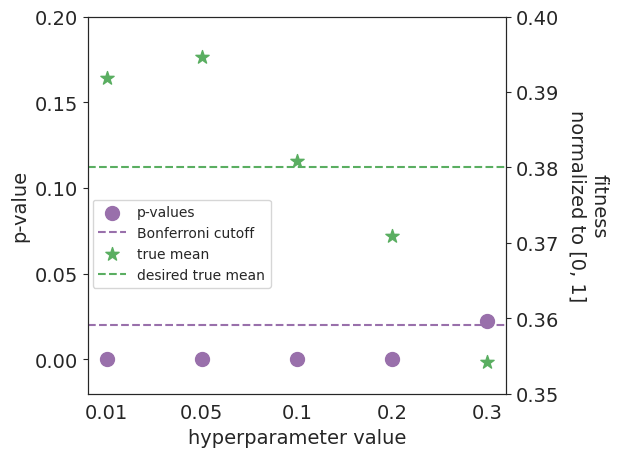

In [108]:
sns.set_style('white')

font = {'size' : 14}
matplotlib.rc('font', **font)

s = 100
m = len(thresholds)
data_color = '#9970AB'
truth_color = '#5AAE61'
fig, ax1 = plt.subplots()

ax1.scatter(range(m), pvals, color=data_color, s=s, label='p-values')
ax1.axhline(alpha / m, linestyle='--', color=data_color, label='Bonferroni cutoff')

ax1.set_ylim([-0.02, 0.2])
ax1.set_yticks(np.arange(0, 0.21, 0.05))
ax1.set_xticks(range(m))
ax1.set_xticklabels(thresholds);
ax1.set_xlabel('hyperparameter value')
ax1.set_ylabel('p-value');

ax2 = ax1.twinx()
ax2.scatter(range(m), truemean_m, marker='*', color=truth_color, s=s, label='true mean')
# ax2.scatter(range(m), classicaltr_m, marker='+', color=data_color, s=s)
ax2.axhline(tau, linestyle='--', color=truth_color, label='desired true mean')
ax2.set_yticks(np.arange(0.35, 0.41, 0.01))
ax2.set_ylabel('fitness\nnormalized to [0, 1]', rotation=270, labelpad=35);
fig.legend(loc=(0.15, 0.37), fontsize=10)
fig.tight_layout() 